# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record



In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
#% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data understanding and cleaning

In [48]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [49]:
#encoding the channels in to 1s and 0s
channels = ['web', 'email', 'mobile', 'social']
for channel in channels:
    portfolio[channel] = portfolio.channels.apply(lambda x: channel in x)*1
    
#droping the channels column
portfolio.drop('channels', axis=1, inplace=True)

In [50]:
# Creating a new column in the dataframe  with concatinating the offer_type with rewards, difficulty and duration
portfolio['offer_name'] = portfolio.offer_type + "_" + portfolio.reward.astype(str) + "_" + portfolio.difficulty.astype(str) + "_" + portfolio.duration.astype(str)
portfolio.rename(columns={"id": "offer_id"}, inplace=True)

In [51]:
portfolio

,reward,difficulty,duration,offer_type,offer_id,web,email,mobile,social,offer_name
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,bogo_10_10_7
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,bogo_10_10_5
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0,informational_0_0_4
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,bogo_5_5_7
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,discount_5_20_10
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,discount_3_7_7
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,discount_2_10_10
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,informational_0_0_3
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,bogo_5_5_5
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0,discount_2_10_7


In [52]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [9]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
gender              14825 non-null object
age                 17000 non-null int64
id                  17000 non-null object
became_member_on    17000 non-null int64
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [10]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [11]:
profile.isna().sum() * 100 / profile.shape[0]

gender              12.794118
age                  0.000000
id                   0.000000
became_member_on     0.000000
income              12.794118
dtype: float64

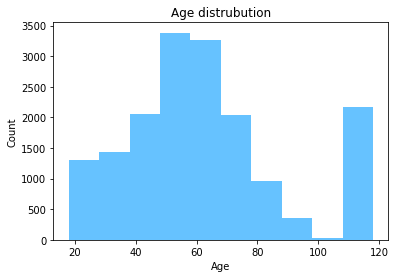

In [12]:
# ploting the age distribution in the profile data
plt.hist(data = profile , x='age',color = '#66c2ff')
plt.title('Age distrubution');
plt.xlabel('Age');
plt.ylabel('Count');

C:\Users\DELL\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\DELL\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


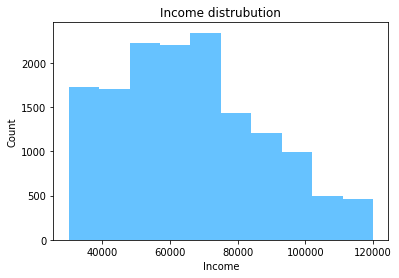

In [13]:
# ploting the income distribution in the profile data
plt.hist(data = profile , x='income',color = '#66c2ff')
plt.title('Income distrubution');
plt.xlabel('Income');
plt.ylabel('Count');

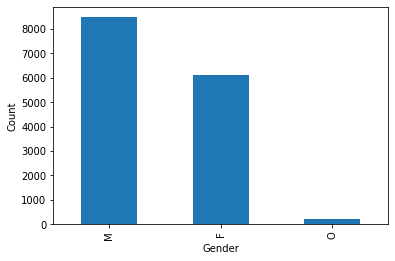

In [14]:
# ploting the gender counts
profile.gender.value_counts().plot(kind='bar')
plt.xlabel('Gender');
plt.ylabel('Count');

In [15]:
profile.id.value_counts().count()

17000

In [16]:
profile[profile['age'] >= 118].count()

gender                 0
age                 2175
id                  2175
became_member_on    2175
income                 0
dtype: int64

In [17]:
# converting the became_member_on column to datetime
profile['became_member_on'] = profile.became_member_on.apply(lambda x: str(x))
profile['became_member_on'] = pd.to_datetime(profile.became_member_on)
profile.rename(columns={"id": "customer_id"}, inplace=True)

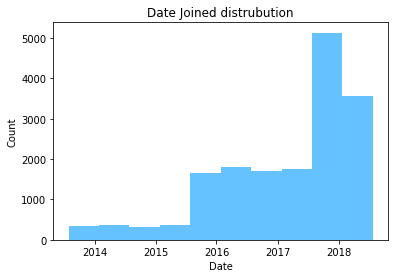

In [18]:
# ploting the date joined distribution in the profile data
plt.hist(data = profile , x='became_member_on',color = '#66c2ff')
plt.title('Date Joined distrubution');
plt.xlabel('Date');
plt.ylabel('Count');

In [19]:
profile.head()

,gender,age,customer_id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN


In [20]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [21]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [22]:
transcript.isna().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [23]:
transcript[transcript['event'] != 'transaction']['person'].count() * 100 / transcript.shape[0]

54.66962881768417

In [24]:
transcript['time'] = transcript.time / 24.0
transcript.rename(columns={"person": "customer_id"}, inplace=True)

In [25]:
def create_offer_id_col(val):
    if list(val.keys())[0] in ['offer id', 'offer_id']:
        return list(val.values())[0]
    
def create_amount_col(val):
    if list(val.keys())[0] in ['amount']:
        return list(val.values())[0]
    
transcript['offer_id'] = transcript.value.apply(create_offer_id_col)
transcript['amount'] = transcript.value.apply(create_amount_col)
transcript.amount.astype('float')
transcript.drop(columns=['value'], inplace=True)

In [26]:
transcript

,customer_id,event,time,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0.00,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0.00,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0.00,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0.00,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN
...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,29.75,None,1.59
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,29.75,None,9.53
306531,a00058cf10334a308c68e7631c529907,transaction,29.75,None,3.61
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,29.75,None,3.53


In [27]:
transcript.duplicated().sum()

397

In [28]:
# drop the duplicated value, and reset the index
transcript.drop_duplicates(inplace=True)
transcript.reset_index(drop=True, inplace=True)

In [29]:
transaction_df = transcript[transcript.event=='transaction'].copy()
transaction_df.drop(columns=['offer_id', 'event'], inplace=True)

In [30]:
transaction_df

,customer_id,time,amount
12654,02c083884c7d45b39cc68e1314fec56c,0.00,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.00,34.56
12659,54890f68699049c2a04d415abc25e717,0.00,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,0.00,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,0.00,18.97
...,...,...,...
306132,b3a1272bc9904337b331bf348c3e8c17,29.75,1.59
306133,68213b08d99a4ae1b0dcb72aebd9aa35,29.75,9.53
306134,a00058cf10334a308c68e7631c529907,29.75,3.61
306135,76ddbd6576844afe811f1a3c0fbb5bec,29.75,3.53


In [31]:
offers_df = transcript[transcript.event != 'transaction'].copy()

# one-hot encode offer event
offers_df['received'] = offers_df.event.apply(lambda x: 1 if x == 'offer received' else 0)
offers_df['completed'] = offers_df.event.apply(lambda x: 1 if x == 'offer completed' else 0)
offers_df['viewed'] = offers_df.event.apply(lambda x: 1 if x == 'offer viewed' else 0)

offers_df.drop(columns=['event', 'amount'], inplace=True)

In [32]:
offers_df

,customer_id,time,offer_id,received,completed,viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,0.00,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0
2,e2127556f4f64592b11af22de27a7932,0.00,2906b810c7d4411798c6938adc9daaa5,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0.00,fafdcd668e3743c1bb461111dcafc2a4,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,0.00,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0
...,...,...,...,...,...,...
306100,a6f84f4e976f44508c358cc9aba6d2b3,29.75,2298d6c36e964ae4a3e7e9706d1fb8c2,0,1,0
306109,b895c57e8cd047a8872ce02aa54759d6,29.75,fafdcd668e3743c1bb461111dcafc2a4,0,1,0
306110,8dda575c2a1d44b9ac8e8b07b93d1f8e,29.75,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,1
306112,8431c16f8e1d440880db371a68f82dd0,29.75,fafdcd668e3743c1bb461111dcafc2a4,0,1,0


In [31]:
# combing the offers_df, transaction_df, portofolio and profile dataframe

data = []

#get the unique customers from the offers_df
customer_ids = offers_df['customer_id'].unique()

# loop through the customer ids in the offer dataframe
for x in range(len(customer_ids)):
    
    # get customer id from the list
    cust_id = customer_ids[x]
        
    # extract customer profile from profile data
    customer = profile[profile['customer_id'] == cust_id]
    
    # extract offers associated with the customer from offers_df
    customer_offer_data = offers_df[offers_df['customer_id'] == cust_id]
        
    # extract transactions associated with the customer from transactions_df
    customer_transaction_data = transaction_df[transaction_df['customer_id'] == cust_id]
    
    # extract received, completed, viewed offer data from customer offers
    offer_received_data = customer_offer_data[customer_offer_data['received'] == 1]
    offer_completed_data = customer_offer_data[customer_offer_data['completed'] == 1]
    offer_viewed_data = customer_offer_data[customer_offer_data['viewed'] == 1]
        
    rows = []
    # loop through each received offer
    for i in range(offer_received_data.shape[0]):
        
        # fetch an offer id 
        offer_id = offer_received_data.iloc[i]['offer_id']
         
        # extract offer row from portfolio
        offer_row = portfolio.loc[portfolio['offer_id'] == offer_id]
        
        # extract duration days of an offer from offer row
        duration_days = offer_row['duration'].values[0]
        
        # initialize start and end time of an offer
        start_time = offer_received_data.iloc[i]['time']
        end_time = start_time + duration_days
        
        # seggregate offers completed within end date
        offer_completed_withintime = np.logical_and(
            offer_completed_data['time'] >= start_time, offer_completed_data['time'] <= end_time)
    
        # seggregate offers viewed within end date
        offer_viewed_withintime = np.logical_and(
            offer_viewed_data['time'] >= start_time, offer_viewed_data['time'] <=end_time)
        
        # flag offer_successful to 1 if an offer is viewed and completed within end time else to 0
        offer_successful = offer_completed_withintime.sum() > 0 and offer_viewed_withintime.sum() > 0
        
        # flag offer_successful_without_view to 1 if an offer is not viewed and completed within end time else to 0
        offer_successful_without_view = offer_completed_withintime.sum() > 0 and  offer_viewed_withintime.sum() ==  0
        
        # extract transactions occured within time
        transaction_withintime = np.logical_and(
            customer_transaction_data['time'] >= start_time, customer_transaction_data['time'] <= end_time)
        
        #transaction data within the offer end time
        transaction_data = customer_transaction_data[transaction_withintime]
        
        # total amount spent by a customer from given offers
        transaction_total_amount = transaction_data['amount'].sum()
        
        row = {
                'offer_id': offer_id,
                'customer_id': cust_id,
                'time': start_time,
                'amount': transaction_total_amount,
                'offer_successful': int(offer_successful),
                'offer_successful_without_viewing': int(offer_successful_without_view),
            }
        
            
        row.update(offer_row.iloc[0,0:].to_dict())

        row.update(customer.iloc[0,:].to_dict())

        rows.append(row)
        
    data.extend(rows)
    
data = pd.DataFrame(data)

KeyboardInterrupt: 

In [95]:
data.to_csv('combined.csv', index=False)

AttributeError: 'list' object has no attribute 'to_csv'

In [15]:
data = pd.read_csv('combined.csv')
data.head()

,offer_id,customer_id,time,amount,offer_successful,offer_successful_without_viewing,reward,difficulty,duration,offer_type,web,email,mobile,social,offer_name,gender,age,became_member_on,income
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,0.0,37.67,1,0,5,5,7,bogo,1,1,1,0,bogo_5_5_7,F,75,2017-05-09,100000.0
1,5a8bc65990b245e5a138643cd4eb9837,78afa995795e4d85b5d9ceeca43f5fef,7.0,49.39,0,0,0,0,3,informational,0,1,1,1,informational_0_0_3,F,75,2017-05-09,100000.0
2,ae264e3637204a6fb9bb56bc8210ddfd,78afa995795e4d85b5d9ceeca43f5fef,17.0,48.28,1,0,10,10,7,bogo,0,1,1,1,bogo_10_10_7,F,75,2017-05-09,100000.0
3,f19421c1d4aa40978ebb69ca19b0e20d,78afa995795e4d85b5d9ceeca43f5fef,21.0,48.28,1,0,5,5,5,bogo,1,1,1,1,bogo_5_5_5,F,75,2017-05-09,100000.0
4,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932,0.0,0.00,0,0,2,10,7,discount,1,1,1,0,discount_2_10_7,M,68,2018-04-26,70000.0


In [16]:
#extract the year from the date column
data['became_member_on'] = data['became_member_on'].apply(lambda x : x[0:4])

In [17]:
# removing outliers
data = data[data['age'] != 118]

In [32]:
data.age.min()

18

In [33]:
data.age.max()

101

In [35]:
# Add the age range column to group the customers in age-ranges
data['age-range'] = pd.cut(x = data['age'], 
                               bins = [17, 20, 30, 40, 50, 60, 70, 80, 90, 105],
                               labels = ['<20','21-30','31-40','41-50','51-60','61-70','71-80','81-90','>90'])

In [38]:
data.income.min()

30000.0

In [39]:
data.income.max()

120000.0

In [40]:
# Add the income range column to group the customers in income-ranges
data['income-range'] = pd.cut(x = data['income'], 
                               bins = [20000, 40000, 50000, 60000, 70000, 80000, 90000, 100000,130000],
                               labels = ['<40k','41-50k','51-60k','61-70k','71-80k','81-90k','91-100k','>100k'])

In [42]:
data.isna().sum().sum()

0

In [59]:
offers_list = []
offers_list.append(data[data['offer_id'] == 'ae264e3637204a6fb9bb56bc8210ddfd']['offer_successful'].mean() * 100)
offers_list.append(data[data['offer_id'] == '4d5c57ea9a6940dd891ad53e9dbe8da0']['offer_successful'].mean() * 100)
offers_list.append(data[data['offer_id'] == '3f207df678b143eea3cee63160fa8bed']['offer_successful'].mean() * 100)
offers_list.append(data[data['offer_id'] == '9b98b8c7a33c4b65b9aebfe6a799e6d9']['offer_successful'].mean() * 100)
offers_list.append(data[data['offer_id'] == '0b1e1539f2cc45b7b9fa7c272da2e1d7']['offer_successful'].mean() * 100)
offers_list.append(data[data['offer_id'] == '2298d6c36e964ae4a3e7e9706d1fb8c2']['offer_successful'].mean() * 100)
offers_list.append(data[data['offer_id'] == 'fafdcd668e3743c1bb461111dcafc2a4']['offer_successful'].mean() * 100)
offers_list.append(data[data['offer_id'] == '5a8bc65990b245e5a138643cd4eb9837']['offer_successful'].mean() * 100)
offers_list.append(data[data['offer_id'] == 'f19421c1d4aa40978ebb69ca19b0e20d']['offer_successful'].mean() * 100)
offers_list.append(data[data['offer_id'] == '2906b810c7d4411798c6938adc9daaa5']['offer_successful'].mean() * 100)

portfolio['completed_percent'] = offers_list

In [60]:
portfolio

,reward,difficulty,duration,offer_type,offer_id,web,email,mobile,social,offer_name,completed_percent
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,bogo_10_10_7,54.646117
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,bogo_10_10_5,51.721523
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0,informational_0_0_4,7.721196
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,bogo_5_5_7,48.287210
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,discount_5_20_10,45.762712
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,discount_3_7_7,72.742299
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,discount_2_10_10,75.285628
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,informational_0_0_3,6.277284
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,bogo_5_5_5,61.618005
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0,discount_2_10_7,47.730357


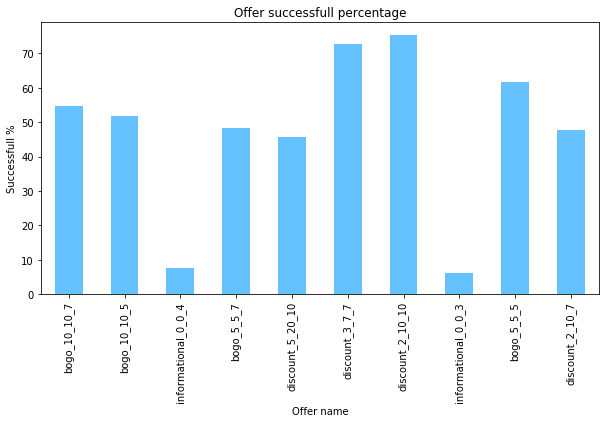

In [65]:
portfolio.plot(kind='bar', 
           x='offer_name',
           y='completed_percent',
           color = '#66c2ff', 
           figsize =(10,5), 
           title = "Offer successfull percentage", 
           legend = False);
plt.xlabel('Offer name');
plt.ylabel('Successfull %');

## Analyze Offer 1) bogo_10_10_7


In [66]:
offer1 = data[data['offer_name'] == 'bogo_10_10_7'] 
offer1 = offer1[offer1['gender'] != 'O']
offer1.head()

,offer_id,customer_id,time,amount,offer_successful,offer_successful_without_viewing,reward,difficulty,duration,offer_type,...,email,mobile,social,offer_name,gender,age,became_member_on,income,age-range,income-range
2,ae264e3637204a6fb9bb56bc8210ddfd,78afa995795e4d85b5d9ceeca43f5fef,17.0,48.28,1,0,10,10,7,bogo,...,1,1,1,bogo_10_10_7,F,75,2017,100000.0,71-80,91-100k
20,ae264e3637204a6fb9bb56bc8210ddfd,aa4862eba776480b8bb9c68455b8c2e1,17.0,60.66,1,0,10,10,7,bogo,...,1,1,1,bogo_10_10_7,F,61,2017,57000.0,61-70,51-60k
28,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,0.0,0.00,0,0,10,10,7,bogo,...,1,1,1,bogo_10_10_7,M,64,2017,100000.0,61-70,91-100k
32,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,21.0,31.05,1,0,10,10,7,bogo,...,1,1,1,bogo_10_10_7,M,64,2017,100000.0,61-70,91-100k
59,ae264e3637204a6fb9bb56bc8210ddfd,1e9420836d554513ab90eba98552d0a9,0.0,0.00,0,0,10,10,7,bogo,...,1,1,1,bogo_10_10_7,M,22,2017,70000.0,21-30,61-70k


In [77]:
k=offer1.groupby(['gender','age-range'])['offer_successful'].mean().reset_index().sort_values(by='offer_successful', ascending=False).head(10)
k['offer_successful'] = k['offer_successful'] * 100
k

,gender,age-range,offer_successful
8,F,>90,67.741935
7,F,81-90,67.619048
5,F,61-70,66.501650
4,F,51-60,65.743440
3,F,41-50,65.239295
2,F,31-40,64.016736
17,M,>90,62.857143
6,F,71-80,60.714286
1,F,21-30,59.302326
16,M,81-90,57.364341


In [80]:
k=offer1.groupby(['gender','income-range'])['offer_successful'].mean().reset_index().sort_values(by='offer_successful', ascending=False).head(10)
k['offer_successful'] = k['offer_successful'] * 100
k

,gender,income-range,offer_successful
5,F,81-90k,72.598870
6,F,91-100k,72.508591
3,F,61-70k,68.103448
14,M,91-100k,68.093385
2,F,51-60k,67.488789
4,F,71-80k,65.756303
15,M,>100k,65.605096
13,M,81-90k,65.156794
7,F,>100k,64.948454
12,M,71-80k,57.317073


In [84]:
k=offer1.groupby(['gender','income-range'])['offer_successful_without_viewing'].mean().reset_index().sort_values(by='offer_successful_without_viewing', ascending=False).head(10)
k['offer_successful_without_viewing'] = k['offer_successful_without_viewing'] * 100
k

,gender,income-range,offer_successful_without_viewing
15,M,>100k,14.012739
14,M,91-100k,9.727626
4,F,71-80k,9.243697
6,F,91-100k,8.591065
7,F,>100k,8.247423
13,M,81-90k,8.013937
5,F,81-90k,7.627119
12,M,71-80k,3.861789
3,F,61-70k,2.011494
10,M,51-60k,1.517241


In [85]:
k=offer1.groupby(['gender','age-range'])['offer_successful_without_viewing'].mean().reset_index().sort_values(by='offer_successful_without_viewing', ascending=False).head(10)
k['offer_successful_without_viewing'] = k['offer_successful_without_viewing'] * 100
k

,gender,age-range,offer_successful_without_viewing
4,F,51-60,6.413994
5,F,61-70,6.270627
7,F,81-90,5.238095
8,F,>90,4.838710
13,M,51-60,4.793757
6,F,71-80,4.761905
14,M,61-70,4.390935
3,F,41-50,4.030227
15,M,71-80,3.977273
16,M,81-90,3.100775


## Analyze Offer 2) bogo_10_10_5

In [87]:
offer2 = data[data['offer_name'] == 'bogo_10_10_5'] 
offer2 = offer2[offer2['gender'] != 'O']
offer2.head()

,offer_id,customer_id,time,amount,offer_successful,offer_successful_without_viewing,reward,difficulty,duration,offer_type,...,email,mobile,social,offer_name,gender,age,became_member_on,income,age-range,income-range
18,4d5c57ea9a6940dd891ad53e9dbe8da0,aa4862eba776480b8bb9c68455b8c2e1,7.0,12.33,1,0,10,10,5,bogo,...,1,1,1,bogo_10_10_5,F,61,2017,57000.0,61-70,51-60k
37,4d5c57ea9a6940dd891ad53e9dbe8da0,c27e0d6ab72c455a8bb66d980963de60,21.0,0.00,0,0,10,10,5,bogo,...,1,1,1,bogo_10_10_5,F,78,2017,71000.0,71-80,71-80k
44,4d5c57ea9a6940dd891ad53e9dbe8da0,f806632c011441378d4646567f357a21,7.0,28.96,1,0,10,10,5,bogo,...,1,1,1,bogo_10_10_5,M,42,2013,69000.0,41-50,61-70k
50,4d5c57ea9a6940dd891ad53e9dbe8da0,d058f73bf8674a26a95227db098147b1,17.0,28.48,1,0,10,10,5,bogo,...,1,1,1,bogo_10_10_5,F,56,2018,88000.0,51-60,81-90k
60,4d5c57ea9a6940dd891ad53e9dbe8da0,1e9420836d554513ab90eba98552d0a9,7.0,35.93,1,0,10,10,5,bogo,...,1,1,1,bogo_10_10_5,M,22,2017,70000.0,21-30,61-70k


In [88]:
k=offer2.groupby(['gender','age-range'])['offer_successful'].mean().reset_index().sort_values(by='offer_successful', ascending=False).head(10)
k['offer_successful'] = k['offer_successful'] * 100
k

,gender,age-range,offer_successful
4,F,51-60,68.128655
7,F,81-90,64.893617
2,F,31-40,64.622642
3,F,41-50,63.814181
8,F,>90,63.768116
5,F,61-70,63.604853
6,F,71-80,61.432507
1,F,21-30,52.631579
15,M,71-80,52.197802
13,M,51-60,50.522648


In [89]:
k=offer2.groupby(['gender','income-range'])['offer_successful'].mean().reset_index().sort_values(by='offer_successful', ascending=False).head(10)
k['offer_successful'] = k['offer_successful'] * 100
k

,gender,income-range,offer_successful
15,M,>100k,77.419355
5,F,81-90k,72.560976
6,F,91-100k,71.379310
7,F,>100k,70.096463
4,F,71-80k,69.477912
13,M,81-90k,66.375546
14,M,91-100k,65.948276
2,F,51-60k,63.037975
3,F,61-70k,62.182741
12,M,71-80k,55.491329


In [90]:
k=offer2.groupby(['gender','age-range'])['offer_successful_without_viewing'].mean().reset_index().sort_values(by='offer_successful_without_viewing', ascending=False).head(10)
k['offer_successful_without_viewing'] = k['offer_successful_without_viewing'] * 100
k

,gender,age-range,offer_successful_without_viewing
8,F,>90,2.898551
15,M,71-80,1.923077
6,F,71-80,1.652893
5,F,61-70,1.559792
16,M,81-90,1.515152
3,F,41-50,1.466993
2,F,31-40,1.415094
4,F,51-60,1.315789
13,M,51-60,1.161440
14,M,61-70,1.112656


In [91]:
k=offer2.groupby(['gender','income-range'])['offer_successful_without_viewing'].mean().reset_index().sort_values(by='offer_successful_without_viewing', ascending=False).head(10)
k['offer_successful_without_viewing'] = k['offer_successful_without_viewing'] * 100
k

,gender,income-range,offer_successful_without_viewing
7,F,>100k,3.215434
15,M,>100k,2.580645
13,M,81-90k,2.183406
4,F,71-80k,1.807229
12,M,71-80k,1.734104
0,F,<40k,1.492537
3,F,61-70k,1.269036
2,F,51-60k,1.265823
5,F,81-90k,1.219512
14,M,91-100k,0.862069


## Analyze Offer 3) bogo_5_5_7

In [96]:
offer3 = data[data['offer_name'] == 'bogo_5_5_7'] 
offer3 = offer3[offer3['gender'] != 'O']
offer3.head()

,offer_id,customer_id,time,amount,offer_successful,offer_successful_without_viewing,reward,difficulty,duration,offer_type,...,email,mobile,social,offer_name,gender,age,became_member_on,income,age-range,income-range
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,0.0,37.67,1,0,5,5,7,bogo,...,1,1,0,bogo_5_5_7,F,75,2017,100000.0,71-80,91-100k
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,e2127556f4f64592b11af22de27a7932,17.0,18.42,1,0,5,5,7,bogo,...,1,1,0,bogo_5_5_7,M,68,2018,70000.0,61-70,61-70k
9,9b98b8c7a33c4b65b9aebfe6a799e6d9,389bc3fa690240e798340f5a15918d5c,7.0,0.00,0,0,5,5,7,bogo,...,1,1,0,bogo_5_5_7,M,65,2018,53000.0,61-70,51-60k
11,9b98b8c7a33c4b65b9aebfe6a799e6d9,389bc3fa690240e798340f5a15918d5c,17.0,15.63,1,0,5,5,7,bogo,...,1,1,0,bogo_5_5_7,M,65,2018,53000.0,61-70,51-60k
51,9b98b8c7a33c4b65b9aebfe6a799e6d9,d058f73bf8674a26a95227db098147b1,21.0,0.00,0,0,5,5,7,bogo,...,1,1,0,bogo_5_5_7,F,56,2018,88000.0,51-60,81-90k


In [97]:
k=offer3.groupby(['gender','income-range'])['offer_successful'].mean().reset_index().sort_values(by='offer_successful', ascending=False).head(10)
k['offer_successful'] = k['offer_successful'] * 100
k

,gender,income-range,offer_successful
14,M,91-100k,61.250000
13,M,81-90k,61.111111
5,F,81-90k,61.046512
3,F,61-70k,58.885942
2,F,51-60k,58.373206
4,F,71-80k,58.212058
6,F,91-100k,56.474820
12,M,71-80k,50.408163
11,M,61-70k,49.763033
0,F,<40k,46.598639


In [100]:
k=offer3.groupby(['gender','age-range'])['offer_successful'].mean().reset_index().sort_values(by='offer_successful', ascending=False).head(10)
k['offer_successful'] = k['offer_successful'] * 100
k

,gender,age-range,offer_successful
3,F,41-50,60.994764
7,F,81-90,58.201058
6,F,71-80,56.983240
4,F,51-60,54.811715
8,F,>90,54.237288
5,F,61-70,52.542373
2,F,31-40,51.190476
13,M,51-60,48.348018
12,M,41-50,47.344461
15,M,71-80,46.898263


In [98]:
k=offer3.groupby(['gender','age-range'])['offer_successful_without_viewing'].mean().reset_index().sort_values(by='offer_successful_without_viewing', ascending=False).head(10)
k['offer_successful_without_viewing'] = k['offer_successful_without_viewing'] * 100
k

,gender,age-range,offer_successful_without_viewing
1,F,21-30,25.925926
2,F,31-40,20.238095
4,F,51-60,20.223152
5,F,61-70,18.135593
6,F,71-80,16.480447
7,F,81-90,16.402116
9,M,<20,15.652174
14,M,61-70,15.384615
15,M,71-80,14.143921
10,M,21-30,13.959391


In [99]:
k=offer3.groupby(['gender','income-range'])['offer_successful_without_viewing'].mean().reset_index().sort_values(by='offer_successful_without_viewing', ascending=False).head(10)
k['offer_successful_without_viewing'] = k['offer_successful_without_viewing'] * 100
k

,gender,income-range,offer_successful_without_viewing
15,M,>100k,30.496454
7,F,>100k,28.526646
1,F,41-50k,20.312500
0,F,<40k,19.727891
5,F,81-90k,17.732558
6,F,91-100k,17.625899
4,F,71-80k,16.424116
9,M,41-50k,16.077739
2,F,51-60k,14.114833
12,M,71-80k,14.081633


## Analyze Offer 3) bogo_5_5_5

In [101]:
offer4 = data[data['offer_name'] == 'bogo_5_5_5'] 
offer4 = offer3[offer3['gender'] != 'O']
offer4.head()

,offer_id,customer_id,time,amount,offer_successful,offer_successful_without_viewing,reward,difficulty,duration,offer_type,...,email,mobile,social,offer_name,gender,age,became_member_on,income,age-range,income-range
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,0.0,37.67,1,0,5,5,7,bogo,...,1,1,0,bogo_5_5_7,F,75,2017,100000.0,71-80,91-100k
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,e2127556f4f64592b11af22de27a7932,17.0,18.42,1,0,5,5,7,bogo,...,1,1,0,bogo_5_5_7,M,68,2018,70000.0,61-70,61-70k
9,9b98b8c7a33c4b65b9aebfe6a799e6d9,389bc3fa690240e798340f5a15918d5c,7.0,0.00,0,0,5,5,7,bogo,...,1,1,0,bogo_5_5_7,M,65,2018,53000.0,61-70,51-60k
11,9b98b8c7a33c4b65b9aebfe6a799e6d9,389bc3fa690240e798340f5a15918d5c,17.0,15.63,1,0,5,5,7,bogo,...,1,1,0,bogo_5_5_7,M,65,2018,53000.0,61-70,51-60k
51,9b98b8c7a33c4b65b9aebfe6a799e6d9,d058f73bf8674a26a95227db098147b1,21.0,0.00,0,0,5,5,7,bogo,...,1,1,0,bogo_5_5_7,F,56,2018,88000.0,51-60,81-90k


In [106]:
k=offer3.groupby(['gender','age-range'])['offer_successful'].mean().reset_index().sort_values(by='offer_successful', ascending=False).head(10)
k['offer_successful'] = k['offer_successful'] * 100
k

,gender,age-range,offer_successful
3,F,41-50,60.994764
7,F,81-90,58.201058
6,F,71-80,56.983240
4,F,51-60,54.811715
8,F,>90,54.237288
5,F,61-70,52.542373
2,F,31-40,51.190476
13,M,51-60,48.348018
12,M,41-50,47.344461
15,M,71-80,46.898263


In [107]:
k=offer3.groupby(['gender','income-range'])['offer_successful'].mean().reset_index().sort_values(by='offer_successful', ascending=False).head(10)
k['offer_successful'] = k['offer_successful'] * 100
k

,gender,income-range,offer_successful
14,M,91-100k,61.250000
13,M,81-90k,61.111111
5,F,81-90k,61.046512
3,F,61-70k,58.885942
2,F,51-60k,58.373206
4,F,71-80k,58.212058
6,F,91-100k,56.474820
12,M,71-80k,50.408163
11,M,61-70k,49.763033
0,F,<40k,46.598639


In [102]:
k=offer4.groupby(['gender','income-range'])['offer_successful_without_viewing'].mean().reset_index().sort_values(by='offer_successful_without_viewing', ascending=False).head(10)
k['offer_successful_without_viewing'] = k['offer_successful_without_viewing'] * 100
k

,gender,income-range,offer_successful_without_viewing
15,M,>100k,30.496454
7,F,>100k,28.526646
1,F,41-50k,20.312500
0,F,<40k,19.727891
5,F,81-90k,17.732558
6,F,91-100k,17.625899
4,F,71-80k,16.424116
9,M,41-50k,16.077739
2,F,51-60k,14.114833
12,M,71-80k,14.081633


In [103]:
k=offer4.groupby(['gender','age-range'])['offer_successful_without_viewing'].mean().reset_index().sort_values(by='offer_successful_without_viewing', ascending=False).head(10)
k['offer_successful_without_viewing'] = k['offer_successful_without_viewing'] * 100
k

,gender,age-range,offer_successful_without_viewing
1,F,21-30,25.925926
2,F,31-40,20.238095
4,F,51-60,20.223152
5,F,61-70,18.135593
6,F,71-80,16.480447
7,F,81-90,16.402116
9,M,<20,15.652174
14,M,61-70,15.384615
15,M,71-80,14.143921
10,M,21-30,13.959391
